# Spectrogram VQGAN as a Neural Vocoder


## Installing the Environment

In [1]:
!pip uninstall torchtext -y # otherwise fails on PytorchLightning import
!pip install pytorch-lightning==1.2.10 omegaconf==2.0.6 #albumentations==0.5.2 opencv-python-headless==4.5.4.58

In [ ]:
# https://github.com/artificalaudio/SpecVQGAN/tree/main

In [2]:
# Cloning the repo from GitHub
!git clone https://github.com/artificalaudio/Neural-Vocoder

%cd Neural-Vocoder

Cloning into 'Neural-Vocoder'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 87 (delta 37), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (87/87), 19.69 MiB | 8.32 MiB/s, done.
/content/Neural-Vocoder


ls: cannot access 'SpecVQGAN': No such file or directory


## Imports and Device Selection

In [3]:
import os
from pathlib import Path
import soundfile
import torch
import IPython
import matplotlib.pyplot as plt


from feature_extraction.demo_utils import (
                                           extract_melspectrogram,
                                          #  get_audio_file_bitrate,
                                           get_duration,
                                           load_model_vocoder)
# from sample_visualization import tensor_to_plt
from torch.utils.data.dataloader import default_collate

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import matplotlib.pyplot as plt
import librosa
import numpy as np

## Select a Model
The model will be automatically downloaded given the `model_name`. 


In [7]:
load_model_vocoder??

In [5]:
model_name = '/content/Neural-Vocoder/vocoder/logs/vggsound/'
# loading the models might take a few minutes
vocoder = load_model_vocoder(device,model_name)

## Select an Audio

The model was pre-trained on `(mels x time) = (80 x 848)`
spectrograms. 
Considering the convolutional nature of the 
Spectrogram VQGAN, it can also be applied to sounds of 
a different duration. 

In [19]:
# Select an Audio
input_wav = '/content/Trumpet_to_ambient_music.wav'

# Spectrogram Extraction
model_sr = 22050
duration = 22.0
spec = extract_melspectrogram(input_wav, sr=model_sr, duration=duration)
print(f'Audio Duration: {duration} seconds')
print('Original Spectrogram Shape:', spec.shape)

def get_input(batch, k):
    x = batch[k]
    if len(x.shape) == 3:
        x = x[..., None]
    x = x.permute(0, 3, 1, 2).to(memory_format=torch.contiguous_format)
    return x.float()

# Prepare Input
spectrogram = {'input': spec}
batch = default_collate([spectrogram])
batch['image'] = batch['input'].to(device)
x = get_input(batch, 'image')

using melspec_10s_22050hz
Audio Duration: 22.0 seconds
Original Spectrogram Shape: (80, 860)


In [8]:
x.shape

torch.Size([1, 1, 80, 860])

## Encoding and Decoding

## Displaying the Results

In [11]:
def magma_plt(x, vmin=None, vmax=None, flip_dims=None):
    if flip_dims is not None:
        # dims is a tuple. To flip only 2nd dim use: `flip_dims=(2,)`
        x = x.flip(dims=flip_dims)
    # remove batch dim and make channel-last
    if len(x.shape) > 3:
        x = x.squeeze(0)
    # if the figure is taller than it is wider rotate (transpose). Also clipping it as feats can be large
    if x.shape[-1] < x.shape[-2]:
        x = x.clip(-2, 2).transpose(-1, -2)
    x = x.cpu()
    if len(x.shape) == 3:
        x = x.permute(1, 2, 0)
    # fig, arr = plt.subplots(nrows=1, ncols=1)
    # # arr[i].set_title(f'{vid_name}_{name}')
    # arr.imshow(x)
    # arr.set_frame_on(False)
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    # for facehq
    # TODO: if x.shape[0] == 3:
    #     x = x.flip(dims=(1,)).permute(1, 2, 0)
    #     x = (x + 1) / 2
    #     x = x.clip(0, 1)

    # newer version of the matplotlib started to fails when an image has 3 dim with `1` as the last one
    if x.ndim == 3 and x.shape[-1] == 1:
        x = x[:, :, 0]
    ax.imshow(x, cmap=plt.get_cmap('magma'), vmin=vmin, vmax=vmax)
    # ax.set_title('Some', fontsize=8)
    return fig

In [20]:
# Save and Display
x = x.squeeze(0)
# specs are in [-1, 1], making them in [0, 1]
wav_x = vocoder((x + 1) / 2).squeeze().detach().cpu().numpy()
# Creating a temp folder which will hold the results
tmp_dir = os.path.join('./tmp/neural_audio_codec', Path(input_wav).parent.stem)
os.makedirs(tmp_dir, exist_ok=True)
# Save paths
x_save_path = Path(tmp_dir) / 'vocoded_orig_spec.wav'
# Save
soundfile.write(x_save_path, wav_x, model_sr, 'PCM_16')
# Display
print('Resynthesised Audio:')
IPython.display.display(IPython.display.Audio(str(x_save_path)))

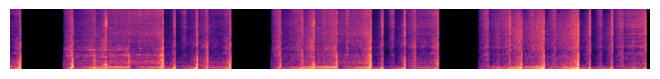

In [22]:
n = magma_plt(x, flip_dims=(2,1))

Original Spectrogram:


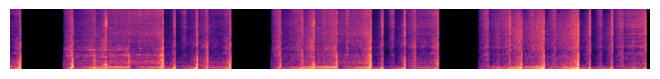

In [23]:
print('Original Spectrogram:')
IPython.display.display(n)
plt.close()

In [ ]:
x.shape

torch.Size([1, 80, 860])

In [ ]:
def magma_plt(x, vmin=None, vmax=None, flip_dims=None):
    if flip_dims is not None:
        # dims is a tuple. To flip only 2nd dim use: `flip_dims=(2,)`
        x = x.flip(dims=flip_dims)
    # remove batch dim and make channel-last
    if len(x.shape) > 3:
        x = x.squeeze(0)
    # if the figure is taller than it is wider rotate (transpose). Also clipping it as feats can be large
    if x.shape[-1] < x.shape[-2]:
        x = x.clip(-2, 2).transpose(-1, -2)
    x = x.cpu()
    if len(x.shape) == 3:
        x = x.permute(1, 2, 0)
    # fig, arr = plt.subplots(nrows=1, ncols=1)
    # # arr[i].set_title(f'{vid_name}_{name}')
    # arr.imshow(x)
    # arr.set_frame_on(False)
    fig = plt.figure(frameon=False)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    # for facehq
    # TODO: if x.shape[0] == 3:
    #     x = x.flip(dims=(1,)).permute(1, 2, 0)
    #     x = (x + 1) / 2
    #     x = x.clip(0, 1)

    # newer version of the matplotlib started to fails when an image has 3 dim with `1` as the last one
    if x.ndim == 3 and x.shape[-1] == 1:
        x = x[:, :, 0]
    ax.imshow(x, cmap=plt.get_cmap('magma'), vmin=vmin, vmax=vmax)
    # ax.set_title('Some', fontsize=8)
    return fig

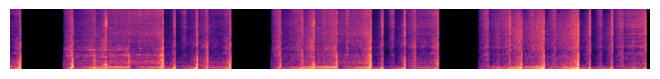

In [ ]:
n = magma_plt(x, flip_dims=(2,1))

In [ ]:
S.shape

(860, 80)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

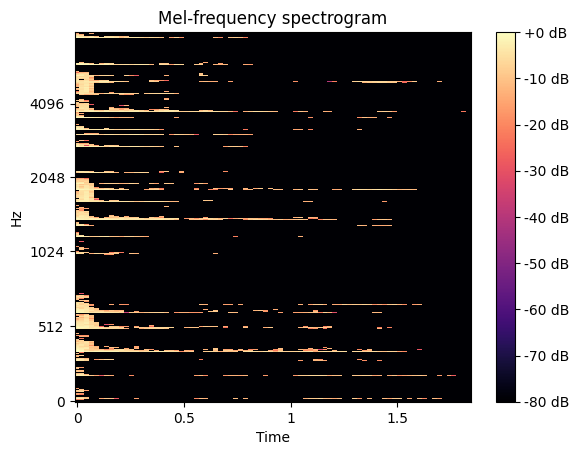

In [ ]:
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=22050,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
plt.plot(x.squeeze(dim=0).numpy())

In [ ]:
!echo "Versions of used packages"
!pip freeze

Versions of used packages
absl-py==1.0.0
aiohttp==3.8.1
aiosignal==1.2.0
alabaster==0.7.12
albumentations==0.5.2
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
asynctest==0.13.0
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.11
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda111==9.4.0
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.27
daft==0.0.4
dask==2.1